In [66]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
np.warnings.filterwarnings('ignore')

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import models, layers
from keras.optimizers import SGD

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score,\
                            roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [43]:
# Tengo que recargar el archivo para que tome los cambios que se hicieron en el mismo

import importlib, sys

#importlib.reload(sys.modules['Preprocessing'])
from Preprocessing import *

In [44]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,32.7,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,32.7,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [45]:
df = normalizar_atributos_numericos(df)
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,0.130337,hombre,0.880653,0.000,0.000000,0.000000,fiumark_quilmes,0.0,0.0
1,4d,0.738202,mujer,0.396985,0.125,0.166667,0.020408,fiumark_quilmes,0.2,0.0
2,normal,0.891011,hombre,0.368090,0.000,0.000000,0.040816,fiumark_chacarita,0.0,0.0
3,4d,0.510112,hombre,0.368090,0.000,0.000000,0.000000,fiumark_palermo,0.0,0.0
4,4d,0.193258,mujer,0.007538,0.125,0.166667,0.020408,fiumark_palermo,0.2,1.0


In [46]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,0.130337,0,1,0.880653,0.000,0.000000,0.000000,0,0,1,0.0,0.0
1,0,0,1,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,0,1,0.2,0.0
2,0,1,0,0.891011,0,1,0.368090,0.000,0.000000,0.040816,0,1,0,0.0,0.0
3,0,0,1,0.510112,0,1,0.368090,0.000,0.000000,0.000000,0,1,1,0.0,0.0
4,0,0,1,0.193258,1,0,0.007538,0.125,0.166667,0.020408,0,1,1,0.2,1.0


# Entrenamiento

In [47]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [48]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,0.130337,0,1,0.880653,0.000,0.000000,0.000000,0,0,1,0.0
1,0,0,1,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,0,1,0.2
2,0,1,0,0.891011,0,1,0.368090,0.000,0.000000,0.040816,0,1,0,0.0
3,0,0,1,0.510112,0,1,0.368090,0.000,0.000000,0.000000,0,1,1,0.0
4,0,0,1,0.193258,1,0,0.007538,0.125,0.166667,0.020408,0,1,1,0.2


In [49]:
n_features = X.columns.size

In [50]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: volveria, dtype: float64

In [51]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [52]:
def generadorRed(n_nuronas=32, n_capas_intermedias=4, lr=0.2):
    
    red = models.Sequential()

    red.add(layers.Dense(units=n_nuronas, activation='relu', input_shape=(n_features, )))

    for _ in range(n_capas_intermedias):
        red.add(layers.Dense(units=n_nuronas, activation='relu'))


    red.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    red.compile(loss='binary_crossentropy',  # Binary Cross Entropy, for Classification 
                optimizer=SGD(lr=lr),  # Stocastic Gradiend Descent
                metrics=['accuracy'])  # Accuracy performance metric TODO VER si esta metrica tiene sentidoS
    return red

In [53]:
#learning_rate = [0.1, 0.2, 0.4, 0.7]
#cantidad_neuronas = [4, 8, 16, 32]
#cantidad_capas = [1, 2, 4, 8, 16]
scoreTotal = []
cantidad_folds = 5
#cantidad_batch = 1

# lr => learning rate
# n_nuronas => cantidad de neuronas
# n_capas_intermedias => cantidad de capas

params = {'lr': [0.1, 0.2, 0.4, 0.7],\
          'n_nuronas': [4, 8, 16, 32],\
         'n_capas_intermedias': [1, 2, 4, 8, 16] }

red_neuronal = KerasClassifier(build_fn=generadorRed,
                              epochs=2000,
                              batch_size=X_train.shape[0],
                              verbose=0
                            )

rgscv = RandomizedSearchCV(
    red_neuronal,
    params, n_iter=60, scoring='accuracy', 
    cv=cantidad_folds, return_train_score=True
).fit(X_train, y_train)

In [54]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.825
Best params {'n_nuronas': 4, 'n_capas_intermedias': 4, 'lr': 0.1}


## Evaluacion

In [55]:
hist = red_neuronal.fit(
    X_train, 
    y_train,
    epochs=2000,
    verbose=2,
    validation_data=(X_test, np.array(y_test)),)

Epoch 1/2000
1/1 - 1s - loss: 0.6970 - accuracy: 0.3125 - val_loss: 0.6833 - val_accuracy: 0.6584
Epoch 2/2000
1/1 - 0s - loss: 0.6859 - accuracy: 0.6062 - val_loss: 0.6737 - val_accuracy: 0.6584
Epoch 3/2000
1/1 - 0s - loss: 0.6787 - accuracy: 0.6062 - val_loss: 0.6669 - val_accuracy: 0.6584
Epoch 4/2000
1/1 - 0s - loss: 0.6737 - accuracy: 0.6062 - val_loss: 0.6613 - val_accuracy: 0.6584
Epoch 5/2000
1/1 - 0s - loss: 0.6695 - accuracy: 0.6062 - val_loss: 0.6566 - val_accuracy: 0.6584
Epoch 6/2000
1/1 - 0s - loss: 0.6657 - accuracy: 0.6062 - val_loss: 0.6519 - val_accuracy: 0.6584
Epoch 7/2000
1/1 - 0s - loss: 0.6619 - accuracy: 0.6062 - val_loss: 0.6474 - val_accuracy: 0.6584
Epoch 8/2000
1/1 - 0s - loss: 0.6581 - accuracy: 0.6062 - val_loss: 0.6431 - val_accuracy: 0.6584
Epoch 9/2000
1/1 - 0s - loss: 0.6541 - accuracy: 0.6062 - val_loss: 0.6389 - val_accuracy: 0.6584
Epoch 10/2000
1/1 - 0s - loss: 0.6500 - accuracy: 0.6062 - val_loss: 0.6348 - val_accuracy: 0.6584
Epoch 11/2000
1/1 -

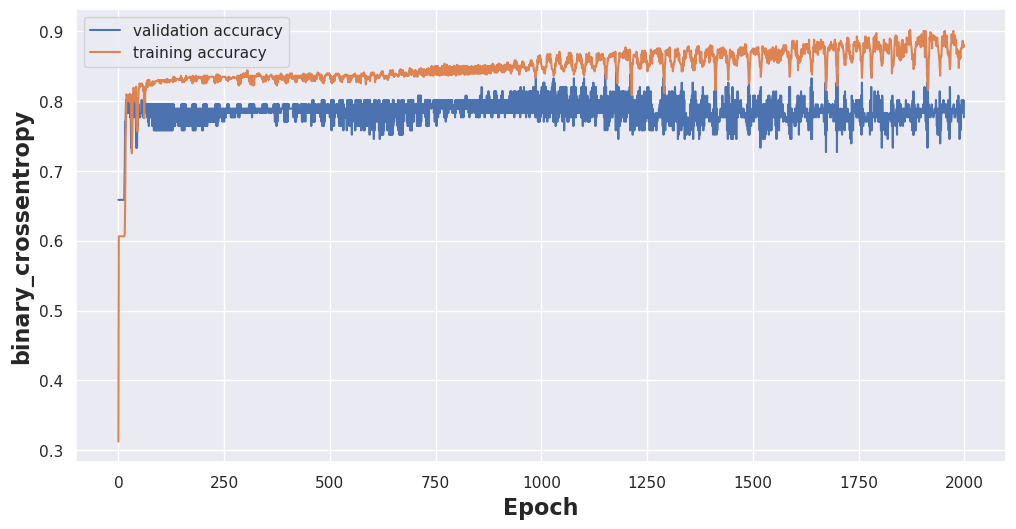

In [57]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(hist.history["val_accuracy"], label="validation accuracy")
plt.plot(hist.history["accuracy"], label="training accuracy")
plt.xlabel("Epoch", weight="bold", fontsize=16)
plt.ylabel("binary_crossentropy", weight="bold", fontsize=16)
plt.legend()

## Metricas

### Accuracy

In [61]:
accuracy_score(y_test, rgscv.predict(X_test))
#np.warnings.filterwarnings('ignore')

0.7888198757763976

### Precision

In [62]:
precision_score(y_test, rgscv.predict(X_test))

0.7441860465116279

### Recall

In [63]:
recall_score(y_test, rgscv.predict(X_test), pos_label=0)

0.8962264150943396

### F1-Score

In [64]:
f1_score(y_test, rgscv.predict(X_test))


0.6530612244897959

### Matriz de confusion

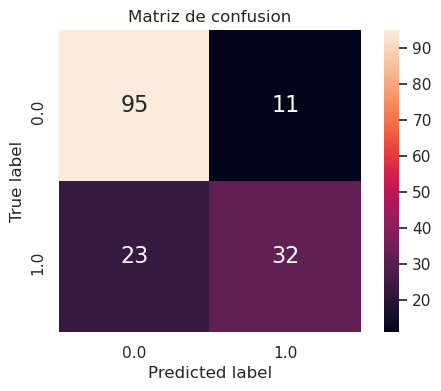

In [67]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, rgscv.predict(X_test))

### Curva AUC ROC

In [68]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

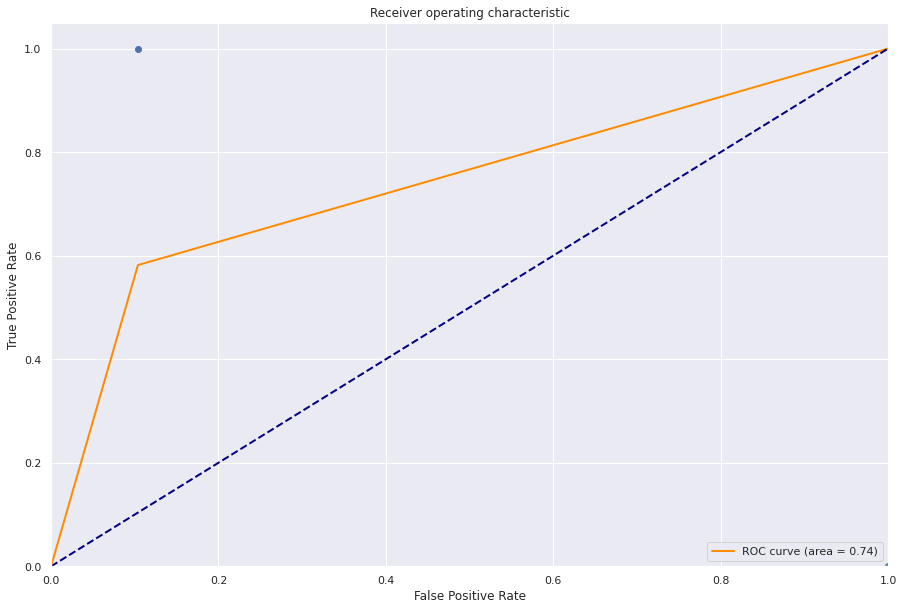

0.7390222984562608

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, rgscv.predict(X_test))
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, rgscv.predict(X_test)))

## Test Holdout

In [ ]:
# TODO: hacer la parte de holdout